# FI-2Pop demo

Demo notebook on the integration of FI-2Pop with the L-System.

## Imports

In [1]:
import json

GECCO-compatible `matplotlib` options:

In [2]:
import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

Import `PCGSEPy` modules:

In [3]:
from pcgsepy.common.vecs import orientation_from_str, Vec 
from pcgsepy.config import COMMON_ATOMS, HL_ATOMS, N_ITERATIONS, REQ_TILES 
from pcgsepy.lsystem.rules import RuleMaker
from pcgsepy.lsystem.actions import AtomAction, Rotations
from pcgsepy.lsystem.parser import HLParser, LLParser
from pcgsepy.lsystem.solver import LSolver
from pcgsepy.lsystem.constraints import ConstraintHandler, ConstraintLevel, ConstraintTime
from pcgsepy.lsystem.constraints_funcs import components_constraint, intersection_constraint, symmetry_constraint, axis_constraint
from pcgsepy.lsystem.lsystem import LSystem
from pcgsepy.structure import block_definitions

## Setup

In [4]:
# import logging

# logging.basicConfig()
# logger = logging.getLogger('base-logger')
# logger.setLevel(logging.WARNING)

In [5]:
with open(COMMON_ATOMS, "r") as f:
    common_alphabet = json.load(f)

for k in common_alphabet:
    action, args = common_alphabet[k]["action"], common_alphabet[k]["args"]
    action = AtomAction(action)
    if action == AtomAction.MOVE:
        args = orientation_from_str[args]
    elif action == AtomAction.ROTATE:
        args = Rotations(args)
    common_alphabet[k] = {"action": action, "args": args}

In [6]:
with open(HL_ATOMS, "r") as f:
    hl_atoms = json.load(f)

tiles_dimensions = {}
tiles_block_offset = {}
for tile in hl_atoms.keys():
    dx, dy, dz = hl_atoms[tile]["dimensions"]
    tiles_dimensions[tile] = Vec.v3i(dx, dy, dz)
    tiles_block_offset[tile] = hl_atoms[tile]["offset"]

hl_alphabet = {}
for k in common_alphabet.keys():
    hl_alphabet[k] = common_alphabet[k]

for hk in hl_atoms.keys():
    hl_alphabet[hk] = {"action": AtomAction.PLACE, "args": []}

In [7]:
ll_alphabet = {}

for k in common_alphabet.keys():
    ll_alphabet[k] = common_alphabet[k]

# for k in block_definitions.keys():
#     if k != "":  # TODO: This is a probable bug, reported to the SE API devs
#         ll_alphabet[k] = {"action": AtomAction.PLACE, "args": [k]}

In [8]:
used_ll_blocks = [
    'MyObjectBuilder_CubeBlock_LargeBlockArmorCorner',
    'MyObjectBuilder_CubeBlock_LargeBlockArmorSlope',
    'MyObjectBuilder_CubeBlock_LargeBlockArmorCornerInv',
    'MyObjectBuilder_CubeBlock_LargeBlockArmorBlock',
    'MyObjectBuilder_Gyro_LargeBlockGyro',
    'MyObjectBuilder_Reactor_LargeBlockSmallGenerator',
    'MyObjectBuilder_CargoContainer_LargeBlockSmallContainer',
    'MyObjectBuilder_Cockpit_OpenCockpitLarge',
    'MyObjectBuilder_Thrust_LargeBlockSmallThrust',
    'MyObjectBuilder_InteriorLight_SmallLight',
    'MyObjectBuilder_CubeBlock_Window1x1Slope',
    'MyObjectBuilder_CubeBlock_Window1x1Flat',
    'MyObjectBuilder_InteriorLight_LargeBlockLight_1corner'
]

for k in used_ll_blocks:
    ll_alphabet[k] = {"action": AtomAction.PLACE, "args": [k]}

## L-System components

In [9]:
hl_rules = RuleMaker(ruleset='hlrules').get_rules()
ll_rules = RuleMaker(ruleset='llrules').get_rules()

hl_parser = HLParser(rules=hl_rules)
ll_parser = LLParser(rules=ll_rules)

hl_solver = LSolver(parser=hl_parser,
                    atoms_alphabet=hl_alphabet,
                    extra_args={
                        'tiles_dimensions': tiles_dimensions,
                        'tiles_block_offset': tiles_block_offset,
                        'll_rules': ll_rules
                    })
ll_solver = LSolver(parser=ll_parser,
                    atoms_alphabet=dict(hl_alphabet, **ll_alphabet),
                    extra_args={})

In [10]:
rcc1 = ConstraintHandler(
    name="required_components",
    level=ConstraintLevel.HARD_CONSTRAINT,
    when=ConstraintTime.END,
    f=components_constraint,
    extra_args={
        'alphabet': hl_alphabet
    }
)
rcc1.extra_args["req_tiles"] = ['cockpit']

rcc2 = ConstraintHandler(
    name="required_components",
    level=ConstraintLevel.HARD_CONSTRAINT,
    when=ConstraintTime.END,
    f=components_constraint,
    extra_args={
        'alphabet': hl_alphabet
    }
)
rcc2.extra_args["req_tiles"] = ['corridorcargo', 'corridorgyros', 'corridorreactors']

rcc3 = ConstraintHandler(
    name="required_components",
    level=ConstraintLevel.HARD_CONSTRAINT,
    when=ConstraintTime.END,
    f=components_constraint,
    extra_args={
        'alphabet': hl_alphabet
    }
)
rcc3.extra_args["req_tiles"] = ['thrusters']

nic = ConstraintHandler(
    name="no_intersections",
    level=ConstraintLevel.HARD_CONSTRAINT,
    when=ConstraintTime.DURING,
    f=intersection_constraint,
    extra_args={
        'alphabet': dict(hl_alphabet, **ll_alphabet)
    },
    needs_ll=True
)
nic.extra_args["tiles_dimensions"] = tiles_dimensions

sc = ConstraintHandler(
    name="symmetry",
    level=ConstraintLevel.SOFT_CONSTRAINT,
    when=ConstraintTime.END,
    f=symmetry_constraint,
    extra_args={
        'alphabet': dict(hl_alphabet, **ll_alphabet)
    }
)

# ax = ConstraintHandler(
#     name="axis1",
#     level=ConstraintLevel.SOFT_CONSTRAINT,
#     when=ConstraintTime.END,
#     f=axis_constraint,
#     extra_args={
#         'alphabet': dict(hl_alphabet, **ll_alphabet)
#     },
#     needs_ll=True
# )

In [11]:
lsystem = LSystem(
    hl_solver=hl_solver, ll_solver=ll_solver, names=['HeadModule', 'BodyModule', 'TailModule']
)

In [12]:
lsystem.add_hl_constraints(cs=[
    [nic, rcc1],
    [nic, rcc2],
    [nic, rcc3]
])

lsystem.add_ll_constraints(cs=[
    [sc],
    [sc],
    [sc]
])

In [13]:
from pcgsepy.evo.genops import expander

expander.initialize(rules=lsystem.hl_solver.parser.rules)

## FI-2Pop

In [14]:
from pcgsepy.config import N_RUNS, EXP_NAME

f_fitnesses_hist = []
i_fitnesses_hist = []

run_experiment = True

In [15]:
from pcgsepy.evo.fitness import box_filling_fitness, bounding_box_fitness, func_blocks_fitness, axis_fitness
from pcgsepy.fi2pop.fi2pop import FI2PopSolver
from pcgsepy.config import N_GENS

fitnesses = [bounding_box_fitness,
             box_filling_fitness,
             func_blocks_fitness,
             axis_fitness]

In [16]:
from pcgsepy.lsystem.structure_maker import LLStructureMaker
from pcgsepy.common.vecs import Orientation
from pcgsepy.structure import Structure
import numpy as np
from pcgsepy.evo.fitness import futo_es, tovo_es, mame_es, mami_es, futo_max, tovo_max, mame_max, mami_max


def save_stats(hl_axiom: str) -> None:
    ml_axiom = lsystem.hl_solver.translator.transform(axiom=hl_axiom)
    ll_axiom = lsystem.ll_solver.solve(axiom=ml_axiom,
                                       iterations=1,
                                       axioms_per_iteration=1,
                                       check_sat=False)[0]

    base_position, orientation_forward, orientation_up = Vec.v3i(
                0, 0, 0), Orientation.FORWARD.value, Orientation.UP.value
    structure = Structure(origin=base_position,
                          orientation_forward=orientation_forward,
                          orientation_up=orientation_up)
    structure = LLStructureMaker(
        atoms_alphabet=lsystem.ll_solver.atoms_alphabet,
        position=base_position).fill_structure(structure=structure,
                                               axiom=ll_axiom)
    structure.sanify()

    functional_blocks_volume, filled_volume = 0., 0.
    for b in structure.get_all_blocks():
        if not b.block_type.startswith('MyObjectBuilder_CubeBlock_'):
            functional_blocks_volume += b.volume
        filled_volume += b.volume

    total_volume = structure.as_array().shape
    total_volume = total_volume[0] * total_volume[1] * total_volume[2]

    futo = functional_blocks_volume / (functional_blocks_volume + filled_volume)
    tovo = (functional_blocks_volume + filled_volume) / total_volume
    volume = functional_blocks_volume + filled_volume

    total_volume = structure.as_array().shape
    largest_axis, medium_axis, smallest_axis = reversed(sorted(list(total_volume)))
    mame = largest_axis / medium_axis
    mami = largest_axis / smallest_axis

    with open(f'{EXP_NAME}_atoms.log', 'a') as f:
        f.write(f'\n\n{hl_axiom}')
        f.write(f'\nVolume: {volume}')
        f.write(f'\nFunctional blocks / total blocks = {futo} ({futo_es.evaluate(futo) / futo_max})')
        f.write(f'\nFilled volume / total volume = {tovo} ({tovo_es.evaluate(tovo) / tovo_max})')
        f.write(f'\nLargest axis / Medium axis = {mame} ({mame_es.evaluate(mame) / mame_max})')
        f.write(f'\nLargest axis / Medium axis = {mami} ({mami_es.evaluate(mami)/ mami_max})')

In [17]:
from tqdm.notebook import trange
import numpy as np

if run_experiment:
    with trange(N_RUNS, desc='Running experiments') as iterations:
        for n in iterations:
            solver = FI2PopSolver(feasible_fitnesses=fitnesses,
                                  lsystem=lsystem)

            f_pop, i_pop, f_fitnesses, i_fitnesses = solver.initialize()

            f_pop, i_pop, f_fitnesses, i_fitnesses = solver.fi2pop(f_pop=f_pop,
                                                                   i_pop=i_pop,
                                                                   f_fitnesses=f_fitnesses,
                                                                   i_fitnesses=i_fitnesses,
                                                                   n_iter=N_GENS)

            f_fitnesses_hist.append(solver.ffs)
            i_fitnesses_hist.append(solver.ifs)

            save_stats(hl_axiom=f_pop[f_fitnesses.index(max(f_fitnesses))])

            iterations.set_postfix(ordered_dict={'f_fit': np.max(f_fitnesses),
                                                 'i_fit': np.min(i_fitnesses)},
                                   refresh=True)

Running experiments:   0%|          | 0/5 [00:00<?, ?it/s]

Initialization :   0%|          | 0/100 [00:00<?, ?it/s]

Created Feasible population of size 20: t:[2.70368437];m:[1.83803612]
Created Infeasible population of size 20: t:1;m:1.25


Generation :   0%|          | 0/30 [00:00<?, ?it/s]

Initialization :   0%|          | 0/100 [00:00<?, ?it/s]

Created Feasible population of size 20: t:[2.772162];m:[1.81916884]
Created Infeasible population of size 20: t:1;m:1.4


Generation :   0%|          | 0/30 [00:00<?, ?it/s]

Initialization :   0%|          | 0/100 [00:00<?, ?it/s]

Created Feasible population of size 20: t:[2.44374459];m:[1.66660115]
Created Infeasible population of size 20: t:1;m:1.3


Generation :   0%|          | 0/30 [00:00<?, ?it/s]

Initialization :   0%|          | 0/100 [00:00<?, ?it/s]

Created Feasible population of size 20: t:[3.14224951];m:[1.87937954]
Created Infeasible population of size 20: t:1;m:1.2


Generation :   0%|          | 0/30 [00:00<?, ?it/s]

Initialization :   0%|          | 0/100 [00:00<?, ?it/s]

Created Feasible population of size 20: t:[2.21629032];m:[1.63452116]
Created Infeasible population of size 20: t:1;m:1.05


Generation :   0%|          | 0/30 [00:00<?, ?it/s]

In [18]:
if run_experiment:
    from pcgsepy.config import POP_SIZE

    ffs = np.empty(shape=(N_RUNS, 1 + N_GENS, 2))
    for r, rv in enumerate(f_fitnesses_hist):
        for g, gv in enumerate(rv):
            ffs[r, g, :] = f_fitnesses_hist[r][g][:]
    ifs = np.empty(shape=(N_RUNS, 1 + N_GENS, 2))
    for r, rv in enumerate(i_fitnesses_hist):
        for g, gv in enumerate(rv):
            ifs[r, g, :] = i_fitnesses_hist[r][g][:]

    with open(f'{EXP_NAME}_metrics.npz', 'wb') as f:
        np.savez(f, ffs, ifs)
else:
    with open(f'{EXP_NAME}_metrics.npz', 'rb') as f:
        npzfile = np.load(f)
        ffs = npzfile['ffs']
        ifs = npzfile['ifs']

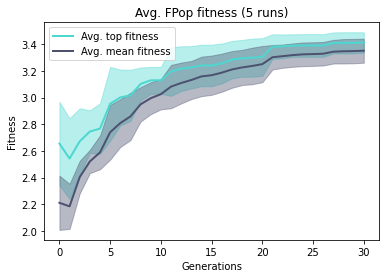

In [30]:
import matplotlib.pyplot as plt

ftfs = np.max(ffs, axis=2)
fmfs = np.mean(ffs, axis=2)

ftm = np.mean(ftfs, axis=0)
fts = np.std(ftfs, axis=0)

fmm = np.mean(fmfs, axis=0)
fms = np.std(fmfs, axis=0)

plt.plot(range(len(ftm)), ftm, label=f'Avg. top fitness', c='#4CD7D0', lw=2)
plt.fill_between(range(len(fts)), (ftm - fts), (ftm + fts), color='#4CD7D0', alpha=0.4)
plt.plot(range(len(fmm)), fmm, label=f'Avg. mean fitness', c='#4C5270', lw=2)
plt.fill_between(range(len(fms)), (fmm - fms), (fmm + fms), color='#4C5270', alpha=0.4)
plt.legend()
plt.title(f'Avg. FPop fitness ({N_RUNS} runs)')
plt.ylabel('Fitness')
plt.xlabel('Generations')
plt.savefig(f'lsystem-fi2pop-fpop-avgf.png', transparent=True)
plt.show()

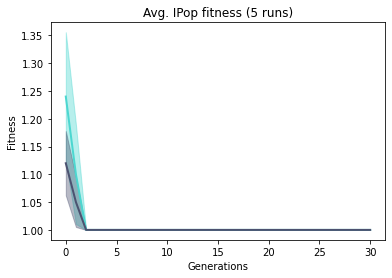

In [31]:
import matplotlib.pyplot as plt

itfs = np.max(ifs, axis=2)
imfs = np.mean(ifs, axis=2)

itm = np.mean(itfs, axis=0)
its = np.std(itfs, axis=0)

imm = np.mean(imfs, axis=0)
ims = np.std(imfs, axis=0)

plt.plot(range(len(itm)), itm, label=f'Avg. top fitness', c='#4CD7D0', lw=2)
plt.fill_between(range(len(its)), (itm - its), (itm + its), color='#4CD7D0', alpha=0.4)
plt.plot(range(len(imm)), imm, label=f'Avg. mean fitness', c='#4C5270', lw=2)
plt.fill_between(range(len(ims)), (imm - ims), (imm + ims), color='#4C5270', alpha=0.4)
plt.title(f'Avg. IPop fitness ({N_RUNS} runs)')
plt.ylabel('Fitness')
plt.xlabel('Generations')
plt.savefig(f'lsystem-fi2pop-ipop-avgf.png', transparent=True)
plt.show()

In [21]:
# from pcgsepy.lsystem.structure_maker import LLStructureMaker
# from pcgsepy.common.vecs import Orientation
# from pcgsepy.structure import Structure

# hl_axiom = f_pop[f_fitnesses.index(max(f_fitnesses))]
# ml_axiom = lsystem.hl_solver.translator.transform(axiom=hl_axiom)
# ll_axiom = lsystem.ll_solver.solve(axiom=ml_axiom,
#                                    iterations=1,
#                                    axioms_per_iteration=1,
#                                    check_sat=False)[0]

# base_position, orientation_forward, orientation_up = Vec.v3i(
#             0, 0, 0), Orientation.FORWARD.value, Orientation.UP.value
# structure = Structure(origin=base_position,
#                       orientation_forward=orientation_forward,
#                       orientation_up=orientation_up)
# structure = LLStructureMaker(
#     atoms_alphabet=lsystem.ll_solver.atoms_alphabet,
#     position=base_position).fill_structure(structure=structure,
#                                            axiom=ll_axiom)
# structure.sanify()
# structure.show(title=' + '.join([f.__name__ for f in fitnesses]))

In [22]:
# print(f'HL AXIOM:\n\t{hl_axiom}')
# # print(f'---\nML AXIOM:\n\t{ml_axiom}')
# # print(f'---\nLL AXIOM:\n\t{ll_axiom}')
# print(f'Length ll: {len(ll_axiom)}')

In [23]:
# functional_blocks_volume, filled_volume = 0., 0.
# for b in structure.get_all_blocks():
#     if not b.block_type.startswith('MyObjectBuilder_CubeBlock_'):
#         functional_blocks_volume += b.volume
#     filled_volume += b.volume

# total_volume = structure.as_array().shape
# total_volume = total_volume[0] * total_volume[1] * total_volume[2]

# futo = functional_blocks_volume / (functional_blocks_volume + filled_volume)
# tovo = (functional_blocks_volume + filled_volume) / total_volume
# volume = functional_blocks_volume + filled_volume

# total_volume = structure.as_array().shape
# largest_axis, medium_axis, smallest_axis = reversed(sorted(list(total_volume)))
# mame = largest_axis / medium_axis
# mami = largest_axis / smallest_axis

In [24]:
# import numpy as np
# from pcgsepy.evo.fitness import futo_es, tovo_es, mame_es, mami_es, futo_max, tovo_max, mame_max, mami_max

# print(f'Volume: {volume}')
# print(f'Functional blocks / total blocks = {np.round(futo, 2)} ({np.round(futo_es.evaluate(futo) / futo_max, 2)})')
# print(f'Filled volume / total volume = {np.round(tovo, 2)} ({np.round(tovo_es.evaluate(tovo) / tovo_max, 2)})')
# print(f'Largest axis / Medium axis = {np.round(mame, 2)} ({np.round(mame_es.evaluate(mame) / mame_max, 2)})')
# print(f'Largest axis / Medium axis = {np.round(mami, 2)} ({np.round(mami_es.evaluate(mami)/ mami_max, 2)})')

In [25]:
# do_place_blocks = False

In [26]:
# if do_place_blocks:
#     from pcgsepy.common.api_call import GameMode, get_base_values, toggle_gamemode
#     from pcgsepy.structure import place_blocks
    
#     base_position, orientation_forward, orientation_up = get_base_values()
#     structure.update(
#         origin=base_position,
#         orientation_forward=orientation_forward,
#         orientation_up=orientation_up,
#     )
#     toggle_gamemode(GameMode.PLACING)
#     place_blocks(structure.get_all_blocks(), False)
#     toggle_gamemode(GameMode.EVALUATING)